In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
from pandas import *
import pickle
from scipy import stats
import torch
import torch.nn as nn
import torch.nn.functional as TF
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import copy
from scipy.stats import entropy
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics.cluster import mutual_info_score
from torch.autograd import grad

from sklearn.cluster import KMeans

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
trainset = datasets.MNIST('data', download=True, train=True, transform=transform)
train_single =torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True, transform=transforms.Compose([
            transforms.ToTensor()
            ])),
        batch_size=1, shuffle=True)
train_batch =torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1000, shuffle=True)
train_full = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=60000, shuffle=True)
test_full = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=10000, shuffle=True)
test_single = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)
test_single_ordered = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=False)

imageNumberDataSet=[]
for i in range(10):
    imageNumberDataSet.append([])
for images,targets in train_full:
    for i in range(60000):
        imageNumberDataSet[targets[i].item()].append(images[i].detach().numpy())
for i in range(10):
    imageNumberDataSet[i]=numpy.array(imageNumberDataSet[i])
    print(i,imageNumberDataSet[i].shape)

testImageNumberDataSet=[]
for i in range(10):
    testImageNumberDataSet.append([])
for images,targets in test_full:
    for i in range(10000):
        testImageNumberDataSet[targets[i].item()].append(images[i].detach().numpy())
for i in range(10):
    testImageNumberDataSet[i]=numpy.array(testImageNumberDataSet[i])
    print(i,testImageNumberDataSet[i].shape)

0 (5923, 1, 28, 28)
1 (6742, 1, 28, 28)
2 (5958, 1, 28, 28)
3 (6131, 1, 28, 28)
4 (5842, 1, 28, 28)
5 (5421, 1, 28, 28)
6 (5918, 1, 28, 28)
7 (6265, 1, 28, 28)
8 (5851, 1, 28, 28)
9 (5949, 1, 28, 28)
0 (980, 1, 28, 28)
1 (1135, 1, 28, 28)
2 (1032, 1, 28, 28)
3 (1010, 1, 28, 28)
4 (982, 1, 28, 28)
5 (892, 1, 28, 28)
6 (958, 1, 28, 28)
7 (1028, 1, 28, 28)
8 (974, 1, 28, 28)
9 (1009, 1, 28, 28)


0 (5923, 1, 28, 28)
1 (6742, 1, 28, 28)
2 (5958, 1, 28, 28)
3 (6131, 1, 28, 28)
4 (5842, 1, 28, 28)
5 (5421, 1, 28, 28)
6 (5918, 1, 28, 28)
7 (6265, 1, 28, 28)
8 (5851, 1, 28, 28)
9 (5949, 1, 28, 28)
0 (980, 1, 28, 28)
1 (1135, 1, 28, 28)
2 (1032, 1, 28, 28)
3 (1010, 1, 28, 28)
4 (982, 1, 28, 28)
5 (892, 1, 28, 28)
6 (958, 1, 28, 28)
7 (1028, 1, 28, 28)
8 (974, 1, 28, 28)
9 (1009, 1, 28, 28)


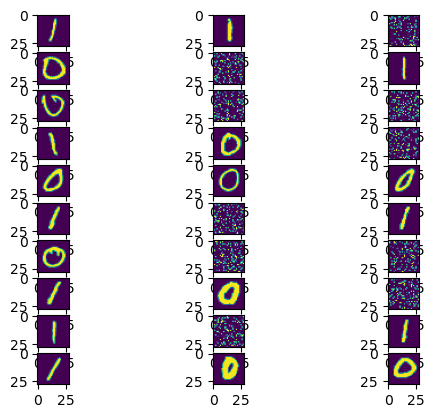

In [4]:
def testOnAllTen(model,imageNumberDataSet,howMany=1000):
    images,targets,ids=makeCFtrainSet(imageNumberDataSet,[0,1,2,3,4,5,6,7,8,9],[howMany]*10,randomizeOrder=False)
    numberIDsOther=[[],[],[],[],[],[],[],[],[],[]]
    numberIDsThis=[[],[],[],[],[],[],[],[],[],[]]
    for i in range(10):
        for j in range(10):
            I=list(range(j*howMany,(j+1)*howMany))
            if j!=i:
                numberIDsOther[i]+=I
            else:
                numberIDsThis[i]+=I
    numberIDsThis=numpy.array(numberIDsThis)
    numberIDsOther=numpy.array(numberIDsOther)
    output=2.0*(model(torch.tensor(images)).detach().numpy().transpose()>0.0)-1.0
    C=list()
    targets=targets.transpose()
    for n in range(10):
        otherID=numpy.random.choice(numberIDsOther[n],(howMany),replace=False)
        TP=(1.0*(targets[n][numberIDsThis[n]]==output[n][numberIDsThis[n]])).sum()
        TN=(1.0*(targets[n][otherID]==output[n][otherID])).sum()
        C.append((TP+TN)/(howMany+howMany))
        #print(ids.shape)
    return C

def makeCFtrainSet(imageNumber,numbers,n,randomizeOrder=True,scrambleNumbers=[]):
    for i,number in enumerate(numbers):
        T=numpy.zeros((10,n[i]))-1.0
        T[number]=numpy.ones((n[i]))
        T=T.transpose()
        I=numpy.array([number]*n[i])
        which=numpy.random.choice(range(len(imageNumber[number])),(n[i]),replace=False)
        if number==numbers[0]:
            images=numpy.array(imageNumber[number][which])
            if number in scrambleNumbers:
                originalShape=images.shape
                images=images.flatten()
                numpy.random.shuffle(images)
                images=images.reshape(originalShape)
            targets=T
            ids=I
        else:
            toAdd=imageNumber[number][which]
            if number in scrambleNumbers:
                originalShape=toAdd.shape
                toAdd=toAdd.flatten()
                numpy.random.shuffle(toAdd)
                toAdd=toAdd.reshape(originalShape)
            images=numpy.concatenate((images,toAdd))
            targets=numpy.concatenate((targets,T))
            ids=numpy.concatenate((ids,I))
    if randomizeOrder:
        order=numpy.random.choice(range(images.shape[0]),(images.shape[0]),replace=False)
        images=images[order]
        targets=targets[order]
        ids=ids[order]
    return images,targets,ids

imageNumberDataSet=[]
for i in range(10):
    imageNumberDataSet.append([])
for images,targets in train_full:
    for i in range(60000):
        imageNumberDataSet[targets[i].item()].append(images[i].detach().numpy())
for i in range(10):
    imageNumberDataSet[i]=numpy.array(imageNumberDataSet[i])
    print(i,imageNumberDataSet[i].shape)

testImageNumberDataSet=[]
for i in range(10):
    testImageNumberDataSet.append([])
for images,targets in test_full:
    for i in range(10000):
        testImageNumberDataSet[targets[i].item()].append(images[i].detach().numpy())
for i in range(10):
    testImageNumberDataSet[i]=numpy.array(testImageNumberDataSet[i])
    print(i,testImageNumberDataSet[i].shape)
    
images,targets,ids=makeCFtrainSet(imageNumberDataSet,[0,1,2],[10,10,10],scrambleNumbers=[2])
for i in range(30):
    subplot(10,3,i+1)
    imshow(images[i][0])

In [104]:
class ComposedNet(nn.Module):
    def __init__(self, input_dim=28*28,hidden_dim=50,output_dim=10,dropout_p=0.0):
        super(ComposedNet, self).__init__()
        self.hiddenLayer=nn.Linear(input_dim,hidden_dim,bias=True)
        self.outputLayer=nn.Linear(hidden_dim,output_dim,bias=True)
        self.output_dim=output_dim
        self.input_dim=input_dim
        self.hidden_dim=hidden_dim
        self.do=nn.Dropout(dropout_p)
        
    def forward(self, x):
        out=x.view(-1,28*28)
        self.hidden=[]
        out=torch.tanh(self.hiddenLayer(self.do(out)))
        self.hidden.append(copy.deepcopy(out.detach().numpy()))
        #out=torch.sigmoid(self.outputLayer(out))
        out=torch.tanh(self.outputLayer(out))
        return out#F.log_softmax(out, dim=1)#out
    
    def forwardWithNodeNoise(self, x,nodes,theVar=0.1):
        out=x.view(-1,28*28)
        self.hidden=[]
        out=torch.tanh(self.hiddenLayer(out))
        self.hidden.append(copy.deepcopy(out.detach().numpy()))
        #out=torch.sigmoid(self.outputLayer(out))
        l=out.shape[0]
        out=torch.transpose(out,0,1).detach().numpy()
        for node in nodes:
            out[node]+=numpy.random.uniform(0.0,theVar,(l))
        out=torch.transpose(torch.tensor(out),0,1)
        out=torch.tanh(self.outputLayer(out))
        return out#F.log_softmax(out, dim=1)#out
    
    def stepBlock(self,x,nodes,block):
        out=x.view(-1,28*28)
        out=torch.tanh(self.hiddenLayer(out))
        out=torch.transpose(out,0,1)
        for node in nodes:
            out[node]=torch.Tensor(block.transpose()[node])
        out=torch.transpose(out,0,1)
        out=torch.tanh(self.outputLayer(out))
        return out
    
    def BackUpWeights(self):
        self.BUweights=copy.deepcopy(self.state_dict())
        
    def block(self,nodes):
        weights=self.state_dict()
        #print(weights["outputLayer.weight"].shape)
        for node in nodes:
            weights["hiddenLayer.weight"][node]=torch.Tensor(numpy.zeros((weights["hiddenLayer.weight"].shape[1])))
            weights["hiddenLayer.bias"][node]=0.0
            for i in range(self.output_dim):
                weights["outputLayer.weight"][i][node]=0.0
        self.load_state_dict(weights)
        
    def toneDownGradients(self,dampening):
        self.hiddenLayer.weight.grad=torch.Tensor((self.hiddenLayer.weight.grad.detach().numpy().transpose()*dampening).transpose())
        self.hiddenLayer.bias.grad*=torch.Tensor(dampening)
        for i in range(self.output_dim):
            self.outputLayer.weight.grad[i]*=torch.Tensor(dampening)
            
    def induceDropout(self,p):
        self.hiddenLayer.weight.grad*=torch.Tensor(1.0*(numpy.random.random((self.hiddenLayer.weight.grad.shape))>p))
        self.hiddenLayer.bias.grad  *=torch.Tensor(1.0*(numpy.random.random((self.hiddenLayer.bias.grad.shape))>p))
        self.outputLayer.weight.grad*=torch.Tensor(1.0*(numpy.random.random((self.outputLayer.weight.grad.shape))>p))
        self.outputLayer.bias.grad*=torch.Tensor(1.0*(numpy.random.random((self.outputLayer.bias.grad.shape))>p))
    
model=ComposedNet(hidden_dim=20)

In [8]:
modelSize=20
model=ComposedNet(28*28,modelSize,10)
optimizer = optim.Adam(model.parameters(),lr=0.001)
error = nn.MSELoss()
for epoch in range(20):
    for image,target in train_batch:
        optimizer.zero_grad()
        targets=numpy.zeros((1000,10))-1.0
        for i,t in enumerate(target):
            targets[i][t]=1.0
        output = model(torch.Tensor(image))
        loss = error(output, torch.Tensor(targets))
        loss.backward()
        optimizer.step()
torch.save(model,"model_hessian_20.model")
trainAT=testOnAllTen(model,imageNumberDataSet)
testAT=testOnAllTen(model,testImageNumberDataSet,howMany=800)
print("train",trainAT)        
print("test",testAT)


NameError: name 'rep' is not defined

In [99]:
model=torch.load("model_hessian_20.model")
subsamples=100
Hs=[]
for i in range(10):
    L=len(imageNumberDataSet[i])
    n=numpy.random.choice(range(L),(subsamples),replace=False)
    images=torch.Tensor(imageNumberDataSet[i][n].reshape((subsamples,-1)))
    t=[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
    t[i]=1.0
    targets=torch.Tensor([t]*subsamples)
    output = model(images)
    loss= TF.cross_entropy(output, targets)
    H = torch.zeros((num_param, num_param))

    # Calculate Jacobian w.r.t. model parameters
    J = torch.autograd.grad(loss, list(model.parameters()), create_graph=True)
    J = torch.cat([e.flatten() for e in J]) # flatten

    # Fill in Hessian
    for i in range(num_param):
        result = torch.autograd.grad(J[i], list(model.parameters()), retain_graph=True)
        H[i] = torch.cat([r.flatten() for r in result]) # flatten
    Hs.append(numpy.diagonal(H))

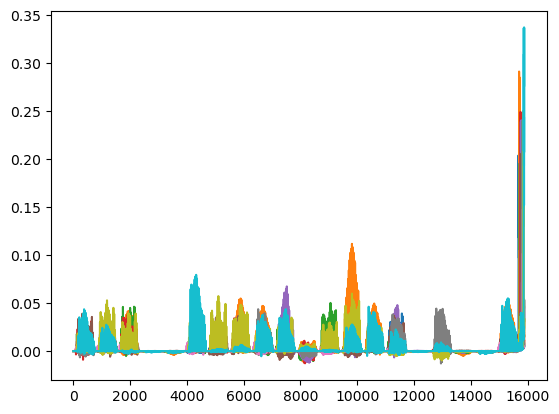

In [100]:
for i in range(10):
    plot(Hs[i])

In [116]:
dr=[0.0,0.025,0.05,0.075,0.1,0.125,0.15,0.175,0.2,0.225,0.25,0.275,0.3]
model=ComposedNet(28*28,20,10)
num_param = sum(p.numel() for p in model.parameters())
for d in dr:
    for n in range(100):
        try:
            model.load_state_dict(torch.load("data100_model/fullModel_MSE_k0_do{0}_rep{1}.model".format(d,n)))
            model.eval()
            subsamples=100
            Hs=[]
            for i in range(10):
                L=len(imageNumberDataSet[i])
                nums=numpy.random.choice(range(L),(subsamples),replace=False)
                images=torch.Tensor(imageNumberDataSet[i][nums].reshape((subsamples,-1)))
                t=[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
                t[i]=1.0
                targets=torch.Tensor([t]*subsamples)
                output = model(images)
                loss= TF.cross_entropy(output, targets)
                H = torch.zeros((num_param, num_param))
                # Calculate Jacobian w.r.t. model parameters
                J = torch.autograd.grad(loss, list(model.parameters()), create_graph=True)
                J = torch.cat([e.flatten() for e in J]) # flatten
                # Fill in Hessian
                for i in range(num_param):
                    result = torch.autograd.grad(J[i], list(model.parameters()), retain_graph=True)
                    H[i] = torch.cat([r.flatten() for r in result]) # flatten
                Hs.append(numpy.diagonal(H))        
            pickle.dump(Hs,open("data100_model/Hs_{0}_{1}.p".format(d,n),"wb"))
            print(d,n)
        except Exception:
            print("missing",d,n)

/var/folders/v5/p_4s6t910c15jfm5gzfn59d00000gq/T/ipykernel_38656/1821154745.py:3: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  num_param = sum(p.numel() for p in model.parameters())


0.0 0
0.0 1
0.0 2
0.0 3
0.0 4
0.0 5
0.0 6
0.0 7
0.0 8
0.0 9
0.0 10
0.0 11
0.0 12
0.0 13
0.0 14
0.0 15
0.0 16
0.0 17
0.0 18
0.0 19
0.0 20
0.0 21
0.0 22
0.0 23
0.0 24
0.0 25
0.0 26
0.0 27
0.0 28
0.0 29
0.0 30
0.0 31
0.0 32
0.0 33
0.0 34
0.0 35
0.0 36
0.0 37
0.0 38
0.0 39
0.0 40
0.0 41
0.0 42
0.0 43
0.0 44
0.0 45
0.0 46
0.0 47
0.0 48
0.0 49
0.0 50
0.0 51
0.0 52
0.0 53
0.0 54
0.0 55
0.0 56
0.0 57
0.0 58
0.0 59
0.0 60
0.0 61
0.0 62
0.0 63
0.0 64
0.0 65
0.0 66
0.0 67
0.0 68
0.0 69
0.0 70
0.0 71
0.0 72
0.0 73
0.0 74
0.0 75
0.0 76
0.0 77
0.0 78
0.0 79
0.0 80
0.0 81
0.0 82
0.0 83
0.0 84
0.0 85
0.0 86
0.0 87
0.0 88
0.0 89
0.0 90
0.0 91
0.0 92
0.0 93
0.0 94
0.0 95
0.0 96
0.0 97
0.0 98
0.0 99
0.025 0
0.025 1
0.025 2
0.025 3
0.025 4
0.025 5
0.025 6
0.025 7
0.025 8
0.025 9
0.025 10
0.025 11
0.025 12
0.025 13
0.025 14
0.025 15
0.025 16
0.025 17
0.025 18
0.025 19
0.025 20
0.025 21
0.025 22
0.025 23
0.025 24
0.025 25
0.025 26
0.025 27
0.025 28
0.025 29
0.025 30
0.025 31
0.025 32
0.025 33
0.025 34
0.025

0.25 13
0.25 14
0.25 15
0.25 16
0.25 17
0.25 18
0.25 19
0.25 20
0.25 21
0.25 22
0.25 23
0.25 24
0.25 25
0.25 26
0.25 27
0.25 28
0.25 29
0.25 30
0.25 31
0.25 32
0.25 33
0.25 34
0.25 35
0.25 36
0.25 37
0.25 38
0.25 39
0.25 40
0.25 41
0.25 42
0.25 43
0.25 44
0.25 45
0.25 46
0.25 47
0.25 48
0.25 49
0.25 50
0.25 51
0.25 52
0.25 53
0.25 54
0.25 55
0.25 56
0.25 57
0.25 58
0.25 59
0.25 60
0.25 61
0.25 62
0.25 63
0.25 64
0.25 65
0.25 66
0.25 67
0.25 68
0.25 69
0.25 70
0.25 71
0.25 72
0.25 73
0.25 74
0.25 75
0.25 76
0.25 77
0.25 78
0.25 79
0.25 80
0.25 81
0.25 82
0.25 83
0.25 84
0.25 85
0.25 86
0.25 87
0.25 88
0.25 89
0.25 90
0.25 91
0.25 92
0.25 93
0.25 94
0.25 95
0.25 96
0.25 97
0.25 98
0.25 99
0.275 0
0.275 1
0.275 2
0.275 3
0.275 4
0.275 5
0.275 6
0.275 7
0.275 8
0.275 9
0.275 10
0.275 11
0.275 12
0.275 13
0.275 14
0.275 15
0.275 16
0.275 17
0.275 18
0.275 19
0.275 20
0.275 21
0.275 22
0.275 23
0.275 24
0.275 25
0.275 26
0.275 27
0.275 28
0.275 29
0.275 30
0.275 31
0.275 32
0.275 33
0.275 34

/var/folders/v5/p_4s6t910c15jfm5gzfn59d00000gq/T/ipykernel_38656/1963394712.py:16: RuntimeWarning: divide by zero encountered in log
  plot(log(numpy.array(A).mean(0)))
/var/folders/v5/p_4s6t910c15jfm5gzfn59d00000gq/T/ipykernel_38656/1963394712.py:16: RuntimeWarning: invalid value encountered in log
  plot(log(numpy.array(A).mean(0)))


missing 0.3 24
missing 0.3 49


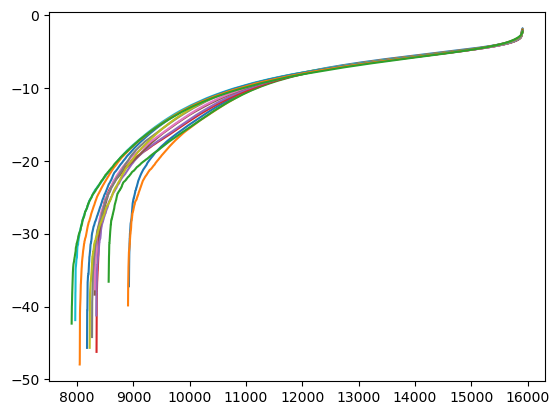

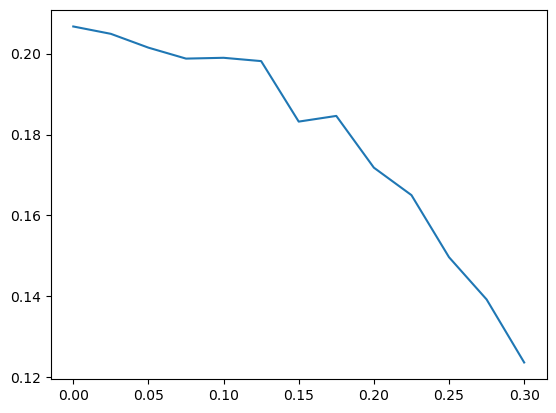

In [128]:
dr=[0.0,0.025,0.05,0.075,0.1,0.125,0.15,0.175,0.2,0.225,0.25,0.275,0.3]
CC=[]
for d in dr:
    A=[]
    C=[]
    for n in range(100):
        try:
            Hs=pickle.load(open("data100_model/Hs_{0}_{1}.p".format(d,n),"rb"))
            A.append(numpy.sort(Hs,1).mean(0))
            for i in range(10):
                for j in range(i+1,10):
                    cc=corrcoef(Hs[i],Hs[j])[0][1]
                    C.append(cc)
        except Exception:
            print("missing",d,n)
    plot(log(numpy.array(A).mean(0)))
    CC.append(mean(C))
figure()
plot(dr,CC)

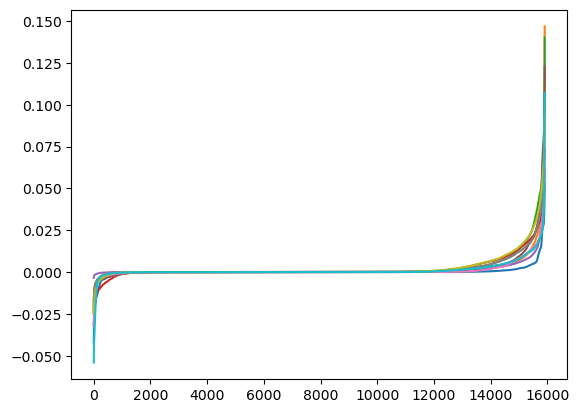

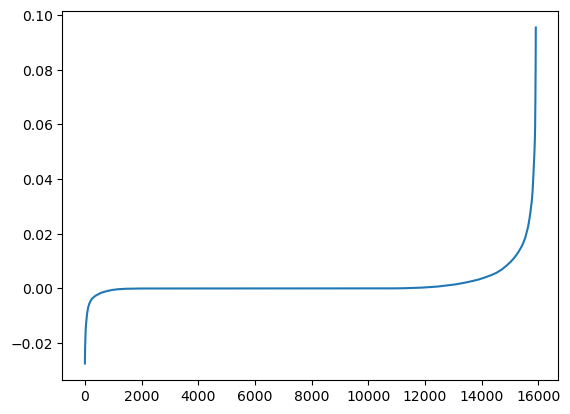

In [125]:
plot()

In [14]:
class Net(nn.Module):
    def __init__(self, h, w):
        super(Net, self).__init__()
        self.c1 = torch.nn.Conv2d(1, 32, 3, 1, 1)
        self.f2 = torch.nn.Linear(32 * h * w, 5)

    def forward(self, x):
        x = self.c1(x)
        x = x.view(x.size(0), -1)
        x = self.f2(x)
        return x

def haha(a, b, c, d):
    p = [a.view(32, 1, 3, 3), b, c.view(5, 32 * 12 * 12), d]
    x = torch.randn(size=[8, 1, 12, 12], dtype=torch.float32)
    y = torch.randint(0, 5, [8])
    x = TF.conv2d(x, p[0], p[1], 1, 1)
    x = x.view(x.size(0), -1)
    x = TF.linear(x, p[2], p[3])
    loss = TF.cross_entropy(x, y)
    return loss


net = Net(12, 12)

h = torch.autograd.functional.hessian(haha, tuple([_.view(-1) for _ in net.parameters()]))
    
    # Then we just need to fix tensors in h into a big matrix

In [27]:
print(inputs.shape, labels.shape)

torch.Size([1000, 784]) torch.Size([1000])


In [57]:
def func_(model, input_data, target):
    output = model(input_data)
    loss = TF.cross_entropy(output, target)
    return loss



# Compute Hessian matrix
parameters = tuple([param for param in model.parameters()])
hessian = torch.autograd.functional.hessian(lambda *p: func_(model, inputs, labels), inputs=parameters)
hessian_combined = torch.cat([torch.cat([h[i][j].view(-1) for j in range(len(h[i]))]) for i in range(len(hessian))])
#hessian_combined = torch.cat([h.view(-1) for h in hessian])
print(hessian_combined.shape)


torch.Size([7476800])


KeyboardInterrupt: 

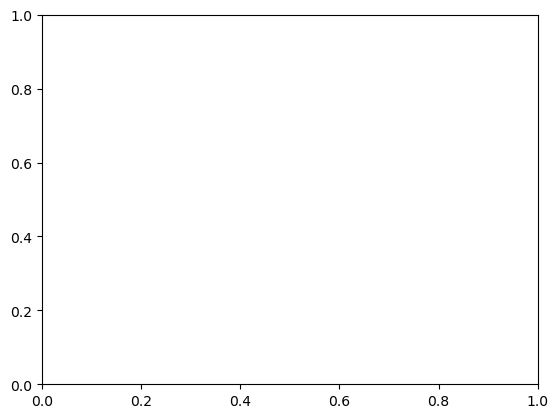

In [59]:
plot(hessian_combined)

In [82]:
model = ComposedNet(28*28,20,10)
num_param = sum(p.numel() for p in model.parameters())

# Evaluate some loss on a random dataset
#x = torch.rand((100,28*28))
#y = torch.rand((100,10))
x=torch.Tensor(images.reshape(30,-1))
y=torch.rand((30,10))
y_hat = model(x)
loss= TF.cross_entropy(y_hat, y)
#loss = ((y_hat - y)**2).mean()

''' Calculate Hessian '''
start = time.time()

# Allocate Hessian size
H = torch.zeros((num_param, num_param))

# Calculate Jacobian w.r.t. model parameters
J = torch.autograd.grad(loss, list(model.parameters()), create_graph=True)
J = torch.cat([e.flatten() for e in J]) # flatten

# Fill in Hessian
for i in range(num_param):
    result = torch.autograd.grad(J[i], list(model.parameters()), retain_graph=True)
    H[i] = torch.cat([r.flatten() for r in result]) # flatten


/var/folders/v5/p_4s6t910c15jfm5gzfn59d00000gq/T/ipykernel_38656/1919593650.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  num_param = sum(p.numel() for p in model.parameters())


-0.0074429857 0.04732005


(array([ 128., 7686., 4453., 1794.,  927.,  516.,  221.,   98.,   33.,
          24.]),
 array([-0.00744299, -0.00196668,  0.00350962,  0.00898592,  0.01446223,
         0.01993853,  0.02541484,  0.03089114,  0.03636744,  0.04184375,
         0.04732005]),
 <BarContainer object of 10 artists>)

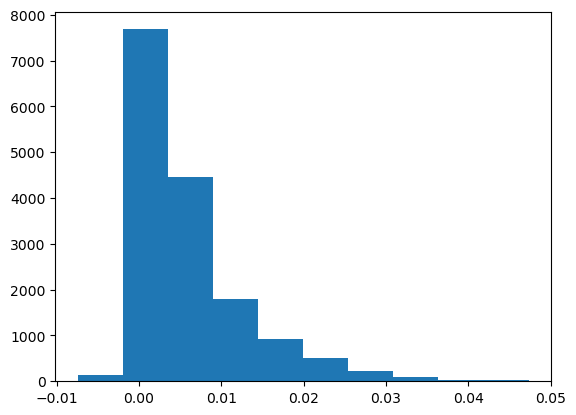

In [83]:
D=numpy.diagonal(H.detach().numpy())
print(D.min(),D.max())
hist(D)

In [85]:
H.shape

torch.Size([15880, 15880])